## Load SDSS image data

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from astropy.io import fits
from astropy.wcs import WCS
import numpy as np

f = fits.open('/home/regier/bliss/tests/data/sdss/2583/2/136/frame-r-002583-2-0136.fits')
w = WCS(f[0].header)

# lower-left corner of the 100x100-pixel study area is at pixel (310, 630)
w.pixel_to_world(310, 630)

In [ ]:
from matplotlib import pyplot as plt

plt.imshow(f[0].data, origin='lower', cmap='Greys_r')
print("Behold, the M2 globular cluster!")

In [ ]:
logimage = np.log(f[0].data - f[0].data.min() + 1)
plt.imshow(logimage, origin='lower', cmap='Greys_r');

In [ ]:
from matplotlib.patches import Rectangle

plt.imshow(logimage, origin='lower', cmap='Greys_r')
rect = Rectangle((310, 630), 100, 100, linewidth=2, edgecolor='r', facecolor='none')
_ = plt.gca().add_patch(rect)
plt.xticks([])
plt.yticks([]);

## Loading/viewing HST predictions

In [ ]:
from bliss.catalog import FullCatalog
import torch
import numpy as np

# wget https://archive.stsci.edu/pub/hlsp/acsggct/ngc7089/hlsp_acsggct_hst_acs-wfc_ngc7089_r.rdviq.cal.adj.zpt
hubble_cat_file = "/home/regier/hlsp_acsggct_hst_acs-wfc_ngc7089_r.rdviq.cal.adj.zpt"
hubble_cat = np.loadtxt(hubble_cat_file, skiprows=3, usecols=(9,21,22))

hst_r_mag_all = torch.from_numpy(hubble_cat[:, 0])
ra = torch.from_numpy(hubble_cat[:, 1])
dec = torch.from_numpy(hubble_cat[:, 2])

plocs_all = FullCatalog.plocs_from_ra_dec(ra, dec, w)

In [ ]:
original = f[0].data[630:730, 310:410]

arcsinh_median = np.arcsinh((original - np.median(original)))

clipped = original.clip(max=np.quantile(original, 0.98))
arcsinh_clipped = np.arcsinh((clipped - np.median(clipped)));

In [ ]:

fig, axs = plt.subplots(1, 3, figsize=(10, 10))

images = [original, arcsinh_median, arcsinh_clipped]
titles = ['original', 'arcsinc', 'arcsinc with clipping']

for i, img in enumerate(images):
    ax = axs[i]
    ax.imshow(img, origin='lower', cmap='Greys_r')
    ax.set_title(titles[i])
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

In [ ]:
in_bounds = (plocs_all[:, 1] > 310) & (plocs_all[:, 1] < 410)
in_bounds &= (plocs_all[:, 0] > 630) & (plocs_all[:, 0] < 730)
in_bounds.sum()

In [ ]:
hst_r_mag = hst_r_mag_all[in_bounds]
plocs = plocs_all[in_bounds]

In [ ]:
plocs_square = plocs - torch.tensor([630, 310])

from bliss.catalog import convert_mag_to_nmgy, convert_nmgy_to_mag
hst_r_nmgy = convert_mag_to_nmgy(hst_r_mag)

# these magnitudes are about 15% off: the hubble fw606 band filter curve
#  isn't exactly the sdss r band filter curve
sdss_r_nmgy = hst_r_nmgy * 1.15
sdss_r_mag = convert_nmgy_to_mag(sdss_r_nmgy)

In [ ]:
d = {
    "plocs": plocs_square.unsqueeze(0),
    "star_fluxes": sdss_r_nmgy.unsqueeze(0).unsqueeze(2).expand([-1, -1, 5]),
    "galaxy_fluxes": sdss_r_nmgy.unsqueeze(0).unsqueeze(2).expand([-1, -1, 5]) * 0.0,
    "n_sources": torch.tensor(plocs.shape[0]).unsqueeze(0),
    "source_type": torch.zeros(plocs.shape[0]).unsqueeze(0).unsqueeze(2).long(),
}

In [ ]:
true_cat_all = FullCatalog(100, 100, d)
true_cat_all["n_sources"].sum()

In [ ]:
true_tile_cat_all = true_cat_all.to_tile_catalog(2, 11)
true_tile_cat_all["n_sources"].sum()

In [ ]:
is_bright = sdss_r_mag < 22.565
is_bright.sum(), convert_mag_to_nmgy(22.565)

In [ ]:
d = {
    "plocs": plocs_square[is_bright].unsqueeze(0),
    "star_fluxes": sdss_r_nmgy[is_bright].unsqueeze(0).unsqueeze(2).expand([-1, -1, 5]),
    "galaxy_fluxes": sdss_r_nmgy[is_bright].unsqueeze(0).unsqueeze(2).expand([-1, -1, 5]) * 0.0,
    "n_sources": torch.tensor(plocs[is_bright].shape[0]).unsqueeze(0),
    "source_type": torch.zeros(plocs[is_bright].shape[0]).unsqueeze(0).unsqueeze(2).long(),
}
true_cat = FullCatalog(100, 100, d)
true_cat["n_sources"].sum()

In [ ]:
true_tile_cat = true_cat.to_tile_catalog(2, 5)
true_tile_cat["n_sources"].sum()

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(10, 10))

cutoffs = [20, 22.065, 24]

for i, cutoff in enumerate(cutoffs):
    is_bright = sdss_r_mag < cutoff
    plocs_square_bright = plocs_square[is_bright]
    ax = axs[i]
    ax.imshow(arcsinh_clipped, origin='lower', cmap='Greys_r')
    ax.scatter(plocs_square_bright[:, 1], plocs_square_bright[:, 0], s=5, c='r')
    ax.set_title(f"magnitude < {cutoff}")
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 100)
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()


## Making predictions on M2 with BLISS

In [ ]:
from os import environ
environ["CUDA_VISIBLE_DEVICES"] = "3"

from hydra import initialize, compose
from bliss.main import predict

with initialize(config_path="../../case_studies/spatial_tiling/", version_base=None):
    cfg = compose("m2_config", {
        "encoder.tiles_to_crop=3",
        "predict.weight_save_path=/home/regier/bliss_output/jul3_m2_split_metrics/version_0/checkpoints/best_encoder.ckpt",
 #       "encoder.use_double_detect=false"
        })

In [ ]:
bliss_cats = predict(cfg.predict)
bliss_cat_pair, = bliss_cats.values()
bliss_cat = bliss_cat_pair["mode_cat"].to_full_catalog()
true_cat["n_sources"].sum(), bliss_cat["n_sources"].sum()

In [ ]:
from hydra.utils import instantiate

matcher = instantiate(cfg.encoder.matcher)
mode_metrics = instantiate(cfg.encoder.mode_metrics)

In [ ]:
matching = matcher.match_catalogs(true_cat, bliss_cat)
metric = mode_metrics(true_cat, bliss_cat, matching)
metric["detection_recall"], metric["detection_precision"], metric["detection_f1"]

In [ ]:
for name, metric in mode_metrics.items():
    metric.plot()

In [ ]:
m = mode_metrics["detection_performance"]
recall = (m.n_true_matches / m.n_true_sources)[:-1]
precision = (m.n_est_matches / m.n_est_sources)[:-1]
real = {"recall": recall, "precision": precision}

Check calibration:

In [ ]:
%%capture
counts = []

for i in range(15):
    bliss_cats = predict(cfg.predict)
    bliss_cat_pair, = bliss_cats.values()
    bliss_cat = bliss_cat_pair["sample_cat"].to_full_catalog()
    counts.append(bliss_cat["n_sources"].sum())

counts

In [ ]:
cs = torch.tensor([c.item() for c in counts]).float()
cs.mean(), cs.quantile(0.05), cs.quantile(0.95)

### Independent tiling (baseline)

In [ ]:
from copy import deepcopy
cfg2 = deepcopy(cfg)
cfg2.encoder.use_checkerboard = False

In [ ]:
bliss_cats = predict(cfg2.predict)
bliss_cat_pair, = bliss_cats.values()
bliss_cat_marginal = bliss_cat_pair["mode_cat"].to_full_catalog()
matching = matcher.match_catalogs(true_cat, bliss_cat_marginal)
metric = mode_metrics(true_cat, bliss_cat_marginal, matching)

m = mode_metrics["detection_performance"]
m.plot()

metric["detection_recall"], metric["detection_precision"], metric["detection_f1"]

In [ ]:
%%capture
counts = []

for i in range(15):
    bliss_cats = predict(cfg2.predict)
    bliss_cat_pair, = bliss_cats.values()
    bliss_cat = bliss_cat_pair["sample_cat"].to_full_catalog()
    counts.append(bliss_cat["n_sources"].sum())

counts

In [ ]:
cs = torch.tensor([c.item() for c in counts]).float()
cs.mean(), cs.quantile(0.05), cs.quantile(0.95)

## BLISS performance on synthetic data

In [2]:
import torch
from hydra import initialize, compose
from hydra.utils import instantiate

with initialize(config_path="../../case_studies/spatial_tiling/", version_base=None):
    cfg3 = compose("m2_config", {
        "train.trainer.logger=null",
        "train.trainer.max_epochs=0",
        "train.pretrained_weights=/home/regier/bliss_output/jul3_m2_split_metrics/version_0/checkpoints/best_encoder.ckpt",
        "+train.trainer.num_sanity_val_steps=0",
        "cached_simulator.num_workers=0",
        "cached_simulator.splits=0:80/80:90/99.5:100",
    })

train_cfg = cfg3.train
dataset = instantiate(train_cfg.data_source)
dataset.setup("fit")
dataset.setup("test")

encoder = instantiate(train_cfg.encoder)
trainer = instantiate(train_cfg.trainer)

enc_state_dict = torch.load(train_cfg.pretrained_weights)
if train_cfg.pretrained_weights.endswith(".ckpt"):
    enc_state_dict = enc_state_dict["state_dict"]
encoder.load_state_dict(enc_state_dict)

trainer.test(encoder, datamodule=dataset)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Testing: 0it [00:00, ?it/s]

/home/regier/bliss/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:54: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [ ]:
# need to disable metric_reset in encoder for this to work!
m = encoder.mode_metrics["detection_performance"]
recall = (m.n_true_matches / m.n_true_sources)[:-1]
precision = (m.n_est_matches / m.n_est_sources)[:-1]
fully_synthetic = {"recall": recall, "precision": precision}
fully_synthetic

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Testing: 0it [00:00, ?it/s]

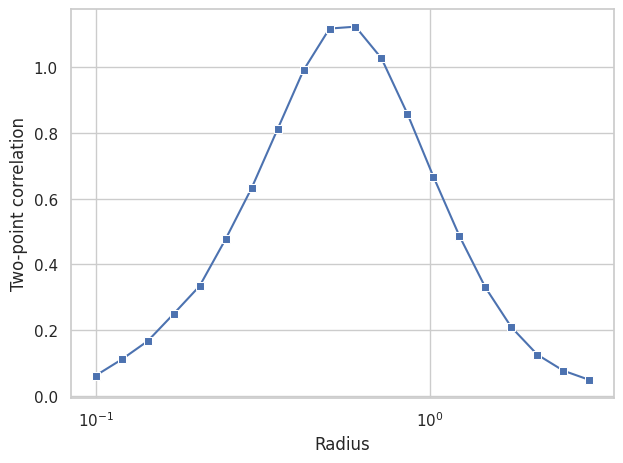

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃             Test metric             ┃            DataLoader 0             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│             test/_loss              │         2.7782750129699707          │
│       test/mode/detection_f1        │         0.7145977020263672          │
│    test/mode/detection_f1_bin_0     │          0.952073335647583          │
│    test/mode/detection_f1_bin_1     │         0.9100860953330994          │
│    test/mode/detection_f1_bin_2     │         0.8836124539375305          │
│    test/mode/detection_f1_bin_3     │         0.8497053980827332          │
│    test/mode/detection_f1_bin_4     │         0.8066278100013733          │
│    test/mode/detection_f1_bin_5     │         0.7531751990318298          │
│    test/mode/detection_f1_bin_6     │         0.6843846440315247          │
│    test/mode/detection_f1_bin_7     │         0.5895228385925293          │
│    test/mode/detection_f1_bin_8     │         0.4815387427806854          │
│    test/mode/detection_precision    │         0.7134124040603638          │
│ test/mode/detection_precision_bin_0 │         0.9693151712417603          │
│ test/mode/detection_precision_bin_1 │         0.9326321482658386          │
│ test/mode/detection_precision_bin_2 │         0.9082474708557129          │
│ test/mode/detection_precision_bin_3 │          0.87432461977005           │
│ test/mode/detection_precision_bin_4 │         0.8290351033210754          │
│ test/mode/detection_precision_bin_5 │         0.7658137083053589          │
│ test/mode/detection_precision_bin_6 │          0.683732807636261          │
│ test/mode/detection_precision_bin_7 │          0.575985312461853          │
│ test/mode/detection_precision_bin_8 │         0.48964300751686096         │
│     test/mode/detection_recall      │          0.715786874294281          │
│  test/mode/detection_recall_bin_0   │         0.9354341626167297          │
│  test/mode/detection_recall_bin_1   │          0.888604462146759          │
│  test/mode/detection_recall_bin_2   │         0.8602786064147949          │
│  test/mode/detection_recall_bin_3   │         0.8264347314834595          │
│  test/mode/detection_recall_bin_4   │         0.7853999733924866          │
│  test/mode/detection_recall_bin_5   │         0.7409469485282898          │
│  test/mode/detection_recall_bin_6   │         0.6850376725196838          │
│  test/mode/detection_recall_bin_7   │         0.6037120819091797          │
│  test/mode/detection_recall_bin_8   │         0.47369834780693054         │
│   test/sample/0.10000000149011612   │         0.06126081943511963         │
│   test/sample/0.11960331350564957   │         0.11037325859069824         │
│   test/sample/0.14304953813552856   │         0.1661388874053955          │
│   test/sample/0.1710919886827469    │         0.24895739555358887         │
│   test/sample/0.20463168621063232   │         0.33384156227111816         │
│   test/sample/0.24474628269672394   │          0.476415753364563          │
│   test/sample/0.2927246689796448    │         0.6315635442733765          │
│   test/sample/0.35010841488838196   │         0.8110380172729492          │
│   test/sample/0.41874128580093384   │         0.9906187057495117          │
│   test/sample/0.5008284449577332    │         1.1173973083496094          │
│   test/sample/0.5990074872970581    │          1.123199462890625          │
│   test/sample/0.7164328098297119    │          1.02689528465271           │
│   test/sample/0.8568774461746216    │          0.857682466506958          │
│   test/sample/1.0248538255691528    │         0.6665520668029785          │
│   test/sample/1.2257591485977173    │         0.4861873388290405          │
│   test/sample/1.4660485982894897    │         0.32943010330200195         │
│   test/sample/1.7534427642822266    │         0.20849037170410156         │
│   test/sample/2.0971

[{'test/_loss': 2.7782750129699707,
  'test/mode/detection_precision': 0.7134124040603638,
  'test/mode/detection_recall': 0.715786874294281,
  'test/mode/detection_f1': 0.7145977020263672,
  'test/mode/detection_precision_bin_0': 0.9693151712417603,
  'test/mode/detection_precision_bin_1': 0.9326321482658386,
  'test/mode/detection_precision_bin_2': 0.9082474708557129,
  'test/mode/detection_precision_bin_3': 0.87432461977005,
  'test/mode/detection_precision_bin_4': 0.8290351033210754,
  'test/mode/detection_precision_bin_5': 0.7658137083053589,
  'test/mode/detection_precision_bin_6': 0.683732807636261,
  'test/mode/detection_precision_bin_7': 0.575985312461853,
  'test/mode/detection_precision_bin_8': 0.48964300751686096,
  'test/mode/detection_recall_bin_0': 0.9354341626167297,
  'test/mode/detection_recall_bin_1': 0.888604462146759,
  'test/mode/detection_recall_bin_2': 0.8602786064147949,
  'test/mode/detection_recall_bin_3': 0.8264347314834595,
  'test/mode/detection_recall_bin

In [3]:
encoder.use_checkerboard = False
trainer.test(encoder, datamodule=dataset)

## Assess the model and BLISS fit visually

In [ ]:

from hydra.utils import instantiate

dataset = instantiate(cfg.predict.dataset)
dataset.prepare_data()

In [ ]:
obs_image = torch.from_numpy(dataset[0]["image"][2][6:-6, 6:-6])

In [ ]:
simulator = instantiate(cfg.simulator)
truth_images, _, _, _ = simulator.image_decoder.render_images(true_tile_cat_all, [(2583, 2, 136)])
true_recon_all = truth_images[0][2] + dataset[0]["background"][2][6:-6, 6:-6]

In [ ]:
bliss_tile_cat = bliss_cat.to_tile_catalog(2, 5)
bliss_images, _, _, _ = simulator.image_decoder.render_images(bliss_tile_cat, [(2583, 2, 136)])
bliss_recon = bliss_images[0, 2] + dataset[0]["background"][2][6:-6, 6:-6]

In [ ]:
titles = ['SDSS image', 'HST reconstruction', 'BLISS reconstruction']

images = [obs_image, true_recon_all, bliss_recon]
images = [img.clip(max=obs_image.quantile(0.99)) for img in images]
images = [np.arcsinh((img - np.median(obs_image))) for img in images]

fig, axs = plt.subplots(1, 3, figsize=(10, 10))

vmin = min(img.min() for img in images)
vmax = max(img.max() for img in images)

for i, img in enumerate(images):
    ax = axs[i]
    ax.imshow(arcsinh_median, origin='lower', vmin=vmin, vmax=vmax)
    ax.set_title(titles[i])
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

# Flux Prior Elicitation

In [ ]:
oob = (plocs_all[:, 1] > 210) & (plocs_all[:, 1] < 510)
oob &= (plocs_all[:, 0] > 530) & (plocs_all[:, 0] < 830)
oob &= ~in_bounds
oob.sum() # some of this region (about half) is outside of our HST cat coverage

In [ ]:
hst_oob = hst_r_mag_all[oob]
hst_oob_nmgy = convert_mag_to_nmgy(hst_oob) * 1.15
hst_oob_mag = convert_nmgy_to_mag(hst_oob_nmgy)
training_data = hst_oob_nmgy[hst_oob_mag < 24]
training_data.shape[0], training_data.max().item()

In [ ]:
from scipy.stats import truncpareto
alpha, trunc, loc, scale = truncpareto.fit(training_data)
alpha, trunc, loc, scale

In [ ]:
from scipy.stats import truncpareto

x = np.logspace(hst_oob_nmgy.log10().min(), hst_oob_nmgy.log10().max(), num=100)

_ = plt.plot(x, truncpareto.pdf(x, alpha, trunc, loc, scale), 'r-', lw=3, alpha=0.7, label='new prior')
_ = plt.plot(x, truncpareto.pdf(x, 0.5, 1014, 0, 0.63), 'g-', lw=3, alpha=0.7, label='old prior')
_ = plt.hist(hst_oob_nmgy, log=True, bins=100, label='star_fluxes histogram', density=True)
plt.legend()

In [ ]:
_ = plt.plot(x, truncpareto.pdf(x, alpha, trunc, loc, scale), 'r-', lw=3, alpha=0.7, label='new prior')
_ = plt.plot(x, truncpareto.pdf(x, 0.5, 1014, 0, 0.63), 'g-', lw=3, alpha=0.7, label='old prior')
plt.legend()
plt.loglog()

In [ ]:
samples = truncpareto.rvs(alpha, trunc, loc, scale, size=1500)
sorted(samples, reverse=True)[:10]


In [ ]:
prior = instantiate(cfg.prior)
prior.sample().on_fluxes[0, :, :, :, 2].view(-1).topk(100)[0]

In [ ]:
# estimate rate with oob data
(hst_oob_mag < 24).sum() / (4 * 1e4)

# Assess the two-point correlation function

In [ ]:
from hydra import initialize, compose
from hydra.utils import instantiate
from bliss.main import train

with initialize(config_path="../../case_studies/spatial_tiling/", version_base=None):
    cfg5 = compose("m2_config", {
        "train.trainer.logger=null",
        "train.trainer.max_epochs=0",
        "train.pretrained_weights=/home/regier/bliss_output/jul3_m2_split_metrics/version_0/checkpoints/best_encoder.ckpt",
        "+train.trainer.num_sanity_val_steps=0",
        "cached_simulator.splits=0:80/80:90/99.5:100",
        "cached_simulator.num_workers=0",
#        "encoder.use_double_detect=false",
    })

# setup dataset, encoder, and trainer
train_cfg = cfg5.train

dataset = instantiate(train_cfg.data_source)
dataset.setup("fit")
dataset.setup("test")

encoder = instantiate(train_cfg.encoder)
trainer = instantiate(train_cfg.trainer)

# load pretrained weights
enc_state_dict = torch.load(train_cfg.pretrained_weights)
if train_cfg.pretrained_weights.endswith(".ckpt"):
    enc_state_dict = enc_state_dict["state_dict"]
encoder.load_state_dict(enc_state_dict)

# test
trainer.test(encoder, datamodule=dataset)

In [ ]:
m = encoder.sample_metrics["two_point"]
two_pt_checkerboard = m.compute().values()
m.reset()
two_pt_checkerboard

Findings from spotchecking sources of nonzero two-point correlation above:
* two pairs of sources with modes within 1e-4: catty corner, need 4 color checkerboard
* one pair of sources with modes within 1e-2: consecutive columns in a row, near a corner; one source a second detect; need conditioning info to second detect
* one pair of sources with sampled modes within 0.1: a double detect solidly within a tile; high uncertainty about whether second exists (it doesn't); first correctly identified; second detected source hovers around the pixel (of 4) containing the source; need conditioning info for the second detect

In [ ]:
encoder.use_checkerboard = False
trainer.test(encoder, datamodule=dataset)

In [ ]:
m = encoder.sample_metrics["TwoPointMetric"]
two_pt_ind = m.compute().values()
two_pt_ind

In [ ]:
radius = [0.01, 0.03, 0.1, 0.3, 1, 3, 10]

plt.figure(figsize=(8, 6))  # Create a new figure with a specific size
plt.plot(radius, two_pt_ind, marker="s", label="independent")
plt.plot(radius, two_pt_checkerboard, label="checkerboard", marker="s")
plt.legend()
plt.xscale("log")  # Set the x-axis scale to logarithmic
plt.xlabel("Radius")
plt.ylabel("Two-point correlation")

plt.tight_layout()
two_pt_ind

# Semi-synthetic M2 inference

In [ ]:
with initialize(config_path="../../case_studies/spatial_tiling/", version_base=None):
    cfg = compose("m2_config", {
        "encoder.tiles_to_crop=3",
        "predict.weight_save_path=/home/regier/bliss_output/jul3_m2_split_metrics/version_0/checkpoints/best_encoder.ckpt",
 #       "encoder.use_double_detect=false"
        })

d2 = deepcopy(true_cat_all)
d2["plocs"] += 6
true_cat_pad = FullCatalog(112, 112, d2)

truth_images, _, _, _ = simulator.image_decoder.render_images(
    true_cat_pad.to_tile_catalog(2, 11), [(2583, 2, 136)]
)

In [ ]:
from torch.distributions import Normal

true_recon_all = truth_images[0] + dataset[0]["background"]
true_recon_all = Normal(true_recon_all, true_recon_all.sqrt()).sample()

In [ ]:
encoder = instantiate(cfg.encoder)
enc_state_dict = torch.load("/home/regier/bliss_output/jul3_m2_split_metrics/version_0/checkpoints/best_encoder.ckpt")
enc_state_dict = enc_state_dict["state_dict"]
encoder.load_state_dict(enc_state_dict)
encoder.eval()

batch = {
    "images": true_recon_all.unsqueeze(0),
    "background": dataset[0]["background"].unsqueeze(0),
}

In [ ]:
encoder.use_checkerboard = False

with torch.no_grad():
    mode_cat, sample_cat = encoder.predict_step(batch, 0).values()

mode_cat = mode_cat.to_full_catalog()
matching = matcher.match_catalogs(true_cat_all, mode_cat)
metric = mode_metrics(true_cat_all, mode_cat, matching)
metric["detection_recall"], metric["detection_precision"], metric["detection_f1"]

In [ ]:
encoder.use_checkerboard = True

with torch.no_grad():
    mode_cat, sample_cat = encoder.predict_step(batch, 0).values()

mode_cat = mode_cat.to_full_catalog()
matching = matcher.match_catalogs(true_cat_all, mode_cat)
metric = mode_metrics(true_cat_all, mode_cat, matching)
metric["detection_recall"], metric["detection_precision"], metric["detection_f1"]

In [ ]:
m = mode_metrics["detection_performance"]
recall = (m.n_true_matches / m.n_true_sources)[:-1]
precision = (m.n_est_matches / m.n_est_sources)[:-1]
semisynthetic = {"recall": recall, "precision": precision}
semisynthetic

In [ ]:
titles = ["fully synthetic", "semi-synthetic", "real"]
scores = [fully_synthetic, semisynthetic, real]

mbc = m.mag_bin_cutoffs
xlabels = [f"[{mbc[i]}, {mbc[i+1]}]" for i in range(len(mbc) - 1)]
xlabels = ["< " + str(mbc[0])] + xlabels + ["> " + str(mbc[-1])]
xlabels = xlabels[:-1]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

for i, score in enumerate(scores):
    axs[0].plot(score["recall"], marker="s", label=titles[i])
    axs[1].plot(score["precision"], marker="s", label=titles[i])

axs[0].set_title("recall")
axs[1].set_title("precision")

for ax in axs:
    ax.set_xticks(range(len(xlabels)))
    ax.set_xticklabels(xlabels, rotation=45)
    ax.set_ylim([0, 1])
    ax.legend()

plt.tight_layout()

# Get asinh parameters

In [ ]:
from hydra import initialize, compose
from hydra.utils import instantiate

with initialize(config_path="../../case_studies/spatial_tiling/", version_base=None):
    cfg = compose("m2_config", {
        "encoder.tiles_to_crop=3",
        "cached_simulator.num_workers=0",
        "cached_simulator.train_transforms=[]"
        })

ds = instantiate(cfg.cached_simulator)
train_dl = ds.train_dataloader()

ss_images = []
for i, datum in enumerate(train_dl.dataset):
    ss = (datum["images"] - datum["background"])[2, 6:-6, 6:-6]
    ss_images.append(ss)
    if i == 1499:
        break


In [ ]:
ss_flat = torch.stack(ss_images, dim=1).view(-1)
q = torch.tensor([0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99, 0.999, 0.9999, 0.99999])
torch.quantile(ss_flat, q)